# Fourth Project: Code Generation

Once semantic analysis are done, we can walk through the decorated AST to generate a linear
N-address code. We call this intermediate machine code as MJIR. So, in this fourth project,
your compiler will emit the intermediate code, and should be able to run this code using a
simple interpreter provided for this purpose.

This notebook is divided in two parts: In the first part, the MJIR is presented and then,
some examples of transformation of an MiniJava program into its MJIR representation are shown.
This part concludes with a short description of the "mj_interpreter" module that should be used
to interpret the MJIR code produced by the compiler.

The second part provides a set of guidelines as well as some pieces of code that should serve
as a guide for building the basic blocks and generating the intermediate code. With a few
exceptions, such as the name of some classes, methods and attributes that interface with the
other components of the compiler and that are explained at this stage, you are free to modify
the provided code.

# Part I: Intermediate Representation

At this stage of the project, you are going to  walk through the decorated AST to generate an
intermediate machine code named MJIR based on [LLVM IR](https://llvm.org/docs/LangRef.html). MJIR
uses a Single Static Assignment (SSA), and can promote stack allocated scalars
to virtual registers and remove the load and store operations, allowing better
optimizations since values propagate directly to their use sites.  The main thing that
distinguishes SSA from a conventional three-address code is that all assignments in SSA
are for distinguished name variables. There are a few important
parts you will need to make this work. Please read this section carefully before beginning.

## Single Static Assignment
The first problem is how to decompose complex expressions into
something that can be handled more simply.  One way to do this is
to decompose all expressions into a sequence of simple assignments
involving binary or unary operations.  

As an example, suppose you have a mathematical expression like this:
```Python
        2 + 3 * 4 - 5
```
Here is one possible way to decompose the expression into simple
operations:
```Python
        %1 = 2
        %2 = 3
        %3 = 4
        %4 = %2 * %3
        %5 = %1 + %4
        %6 = 5
        %7 = %5 - %6
```
In this code, the **%n** variables are simply temporaries used while
carrying out the calculation.  A critical feature of SSA is that such
temporary variables are only assigned once (single assignment) and
never reused.  Thus, if you were to evaluate another expression, you
would simply keep incrementing the numbers. For example, if you were
to evaluate **10 + 20 + 30**, you would have code like this:
```Python
        %8 = 10
        %9 = 20
        %10 = %8 + %9
        %11 = 30
        %12 = %10 + %11
```
SSA is meant to mimic the low-level instructions one might carry out
on a CPU.  Another benefit of SSA is that it is very easy to encode and
manipulate using simple data structures such as tuples. For example,
you could encode the above sequence of operations as a list like this:

```python
       [
         ('store', 2, '%1'),
         ('store', 3, '%2'),
         ('store', 4, '%3'),
         ('mul', '%2', '%3', '%4'),
         ('add', '%1', '%4', '%5'),
         ('store', 5, '%6'),
         ('sub', '%5', '%6', '%7'),
       ]
```

### Dealing with Variables
In your program, you are probably going to have some variables that get
used and assigned different values.  For example:
```Python
       a = 10 + 20;
       b = 2 * a;
       a = a + 1;
```
In "pure SSA", all of your variables would actually be versioned just
like temporaries in the expressions above.  For example, you would
emit code like this:
```Python
       %1 = 10
       %2 = 20
       a_1 = %1 + %2
       %4 = 2
       b_1 = %4 * a_1
       %5 = 1
       a_2 = a_1 + %5
       ...
```
To avoid this, we're going to treat declared variables as memory locations and access
them using load/store instructions.  For example:
```Python
       %1 = 10
       %2 = 20
       %3 = %1 + %2
       store(%3, "a")
       %4 = 2
       %5 = load("a")
       %6 = %4 * %5
       store(%6, "b")
       %7 = load("a")
       %8 = 1
       %9 = %7 + %8
       store(%9, "a")
```

### A Word About Types
At a low-level, CPUs can only operate a few different kinds of
data such as ints and floats.  Because the semantics of the
low-level types might vary slightly, you'll need to take
some steps to handle them separately.

In our intermediate code, we're simply going to tag temporary variable
names and instructions with an associated type low-level type.  For
example:

      2 + 3 * 4     (ints)
      'a' == 'b'    (chars)

The generated intermediate code might look like this:

```python
      ('literal_int', 2, '%1')
      ('literal_int', 3, '%2')
      ('literal_int', 4, '%3')
      ('mul_int', '%2', '%3', '%4')
      ('add_int', '%1', '%4', '%5')

      ('literal_char', 'a', '%6')
      ('literal_char', 'b', '%7')
      ('eq_char', '%6', '%7', '%8')
```

## Your Task
Your task is as follows: Write an AST Visitor() class that takes an
MiniJava program and flattens it to a single sequence of SSA code instructions
represented as tuples of the form
```python
(operation, operands, ..., destination)
```
Your SSA code should only contain the following operators:

### Variables & Values:
```python
('alloc_type', varname)              # Allocate on stack (ref by register) a variable of a given type.
('global_type', varname, value)      # Allocate on heap a global var of a given type. value is optional.
('load_type', varname, target)       # Load the value of a variable (stack/heap) into target (register).
('store_type', source, target)       # Store the source/register into target/varname.
('literal_type', value, target)      # Load a literal value into target.
('elem_type', source, index, target) # Load into target the address of source (array) indexed by index.
('get_type', source, target)         # Store into target the address of source.
```

### Binary Operations:
```python
('add_type', left, right, target)   # target = left + right
('sub_type', left, right, target)   # target = left - right
('mul_type', left, right, target)   # target = left * right
('div_type', left, right, target)   # target = left / right  (integer truncation)
('mod_type', left, right, target)   # target = left % rigth
```

### Unary Operations:
```python
('not_type', expr, target)          # target = !expr
```

### Relational/Equality/Logical:
```python
('oper_type', left, right, target)   # target = left `oper` rigth, where `oper` is:
                                     #          lt, le, ge, gt, eq, ne, and, or, not
```

### Labels & Branches:
```python
('label:', )                                       # Label definition
('jump', target)                                   # Jump to a target label
('cbranch', expr_test, true_target, false_target)  # Conditional Branch
```

### Classes:
```python
('class', name, parent)          # Class definition.
                                 # name=@<class name>
                                 # parent=parent class
('field', class_field, init)     # Field definition.
                                 # class_field=Identifier in the format @<class>.field_name
                                 # init=Initial value (default is None) or array size (see array section)
('define_type', source, args)    # Method definition. Source=function label, args=list of pairs
                                 # (type, name) of formal arguments.

```

### Builtins:

```python
('call_type', source, target)    # Call a Method. target is an optional return value
('return_type', target)          # Return from Method. target is an optional return value
('param_type', source)           # Source is an actual parameter
('print_type', source)           # Print value of source
('new_type', target)             # Creates a new object of the type and stores it in the it on target
('length', source, target)       # Load the length of source in target
```

## MJIR Example
Below you find a simple example of the intermediate representation (IR) for the given MiniJava
program. More examples are provided in the [MJIR_Examples](https://colab.research.google.com/drive/1I9y3NIRoi9ur1EsVgl1wMfOVksiIjzGj?usp=sharing) notebook.

MiniJava:
```java
class Main {
    int n = 10;

    public int foo(int a, int b) {
        return this.n * (a + b);
    }

    public static void main(String[] args) {
        Main obj = new Main();
        int c = 2, d = 3;
        int e = obj.foo(c, d);
    }
}
```

IR:
```python
('class', '@Main', None)
('field_int', '@Main.n', 10)
('define_int', '@Main.foo', [('int', '%1'), ('int', '%2')]),
# Method arguments: the value for "a" is passsed in register %1, for "b" in register %2
# & register %3 is reserved to hold the return value (note that %0 is reserved by the Interpreter)
('entry:',)
('alloc_int', '%3')
('alloc_int', '%a')
('alloc_int', '%b')
('store_int', '%1', '%a')
('store_int', '%2', '%b')
('load_int', '%a', '%4')
('load_int', '%b', '%5')
('add_int', '%4', '%5', '%6')
('load_int', '%this.n', '%7')
('load_int', '%6', '%8')
('mul_int', '%7', '%8', '%9')
('store_int', '%9', '%3')
('jump', '%exit')
('exit:',)
('load_int', '%3', '%10')
('return_int', '%10')

('define_void', '@Main.main', [('String[]', '%args')]),
# The main in MiniJava has only one argument, only register %args is reserved
# Remember that register %0 is reserved by the Interpreter
('entry:',)
('new_@Main', '%obj')
('literal_int', 2, '%1')
('alloc_int', '%c')
('store_int', '%1', '%c')
('literal_int', 3, '%2')
('alloc_int', '%d')
('store_int', '%2', '%d')
('load_int', '%c', '%3')
('param_int', '%3')
('load_int', '%d', '%4')
('param_int', '%4')
('call_int', '%obj.foo', '%5')
('alloc_int', '%e')
('store_int', '%5', '%e')
('jump', '%exit')
('exit:',)
('return_void',)
```

### Prettyprint
We have applied a stylistic formatting to the MJIR intermediate representation to facilitate reading the content
so that you can see, read and understand it more easily. To do this, you can use the following function
that can be adapted to your style. Just note that this function should be defined, without changing its
name, in the ```mj_block``` module because it is used by the interpreter to view the code under debugging.

In [ ]:
def format_instruction(t: tuple) -> str:
    """Pretty prints instruction.

    ## Parameters
    - :param t: instruction

    ## Return
    - :return: The formatted instruction t'
    """
    operand = t[0].split("_")
    op = operand[0]
    ty = operand[1] if len(operand) > 1 else None
    if len(operand) >= 3:
        for _qual in operand[2:]:
            if _qual == "*":
                ty += "*"
            else:
                ty += f"[{_qual}]"
    if len(t) > 1:
        if op == "define":
            return (
                f"{op} {ty} {t[1]} ("
                + ", ".join(list(" ".join(el) for el in t[2]))
                + ")"
            )
        elif op == "class":
            extends = "" if t[2] is None else f" extends {t[2]}"
            return f"\n{op} {t[1]}{extends}"
        elif op == "field":
            init_value = "" if t[2] is None else f" init = {t[2]}"
            return f"{op} {ty} {t[1]}{init_value}"
        else:
            _str = "" if op == "global" else "  "
            if op == "jump":
                _str += f"{op} label {t[1]}"
            elif op == "cbranch":
                _str += f"{op} {t[1]} label {t[2]} label {t[3]}"
            elif op == "global":
                if ty.startswith("String"):
                    _str += f"{t[1]} = {op} {ty} '{t[2]}'"
                elif len(t) > 2:
                    _str += f"{t[1]} = {op} {ty} {t[2]}"
                else:
                    _str += f"{t[1]} = {op} {ty}"
            elif op == "return" or op == "print":
                _str += f"{op} {ty} {t[1]}"
            elif op == "sitofp" or op == "fptosi":
                _str += f"{t[2]} = {op} {t[1]}"
            elif op == "store" or op == "param":
                _str += f"{op} {ty} "
                for _el in t[1:]:
                    _str += f"{_el} "
            else:
                _str += f"{t[-1]} = {op} {ty} "
                for _el in t[1:-1]:
                    _str += f"{_el} "
            return _str
    elif ty == "void":
        return f"  {op}"
    else:
        return f"{op}"

Next, the previous example is presented in this format. All the examples
to follow in this and other notebooks will follow this formatting style.

```Python
class @Main
field int @Main.n init = 10
define int @Main.foo (int %1, int %2)
entry:
  %3 = alloc int
  %a = alloc int
  %b = alloc int
  store int %1 %a
  store int %2 %b
  %4 = load int %a
  %5 = load int %b
  %6 = add int %4 %5
  %7 = load int %this.n
  %8 = load int %6
  %9 = mul int %7 %8
  store int %9 %3
  jump label %exit
exit:
  %10 = load int %3
  return int %10
define void @Main.main (String[] %args)
entry:
  %obj = new @Main
  %1 = literal int 2
  %c = alloc int
  store int %1 %c
  %2 = literal int 3
  %d = alloc int
  store int %2 %d
  %3 = load int %c
  param int %3
  %4 = load int %d
  param int %4
  %5 = call int %obj.foo
  %e = alloc int
  store int %5 %e
  jump label %exit
exit:
  return
```

### A note about arrays
The dimensions of an Array in the MiniJava are known at compile time. Then, the type described
in the allocation must express the dimension of the same. The initializer_list are always
allocated in the heap, either directly in the declaration of the variable, if it is
global, or by defining a new temporary, based on the name of the local variable. Examples:

MiniJava:
```java
class ArrayExample1 {
    int[] x = {1, 2, 3};
    public static void main(String[] args) {}
}
```
IR:
```Python
('class', '@ArrayExample1', None)
('field_int[]', '@ArrayExample1.x', [1, 2, 3])
('define_void', '@ArrayExample1.main', [('String[]', '%args')])
('entry:',)
('jump', '%exit')
('exit:',)
('return_void',)
```

MiniJava:
```java
class ArrayExample2 {
    int[] x = {1, 2};
    int[] v = new int[5];
    public static void main(String[] args) {
        int[] y = {1, 2, 3};
        int[] z = new int[10];
        this.v[0] = 5;
        print(this.v[0]);
    }
}
```
IR:
```Python
('global_int[]_3', '@.const_y.0', [1, 2, 3]),
('class', '@ArrayExample2', None),
('field_int[]', '@ArrayExample2.x', [1, 2]),
('field_int[]', '@ArrayExample2.v', 5),
('define_void', '@ArrayExample2.main', [('String[]', '%args')]),
('entry:',),
('alloc_int[]_3', '%y'),
('store_int[]_3', '@.const_y.0', '%y'),
('new_int[]_10', '%z'),
('literal_int', 0, '%1'),
('elem_int', '%this.v', '%1', '%2'),
('literal_int', 5, '%3'),
('store_int_*', '%3', '%2'),
('literal_int', 0, '%4'),
('elem_int', '%this.v', '%4', '%5'),
('load_int_*', '%5', '%6'),
('print_int', '%6'),
('jump', '%exit'),
('exit:',),
('return_void',)

```

## Run the MJIR in the Interpreter

Once you've got your compiler emitting intermediate code, you should be able to runs
the code in the *mj_interpreter.py*. This can be useful for
testing, and other tasks involving the generated code.

You can think the Interpreter as a kind of stack machine, which means
that most instructions take their operands from the stack, and place
results back on the stack.

It defines a memory model that consists of a program memory (the code),
a dictionary to hold references (indexes) to vars, labels & registers
in the memory (M). All the data areas of M are divided into cells,
and each cell can hold a single value. The actual size of a cell is
large enough to hold single values (int, char, bool and ref) or any
element of string (chars) and arrays. For simplicity, we use a separate
dictionary to hold the indexes of globals vars and constants.
These vars & constants will be previously stored at begining of the
memory by the interpreter before start running the program.

The Interpreter uses a program counter “pc” to fetches instructions
from the code. In this model, the M stack does not act as a function
stack for holding function linkage information but only data. It
 uses auxiliares stack and dictionaries to holding these informations.


# Part II: Generating Code

This second part provides a set of guidelines as well as some pieces of code that should serve
as a guide for building the basic blocks and generating the intermediate code.

## Basic Block Creation

During the construction of the sequence of instructions in its intermediate representation
for the program, you need to build the basic blocks. A basic block is a sequence of
instructions where the control flow enters only at the beginning of the block and exits
at the end of the block, without the possibility of deviation to any other part of the
program. The basic blocks make up the nodes of a control flow graph (CFG), a structure
that will be important for performing code optimizations.

To create the CFG blocks order, you need to arrange the created blocks in a linked list format, using the ```next_block``` attribute of a block. If a recently created block was not shown in the output, maybe you forgot to update the ```next_block``` attribute to link to it.

When building the basic blocks, you may note that the first statement of a basic block
is always a label and the last statement is a jump statement (conditional or unconditional).
Function calls should be treated as straight-line IR nodes (i.e., they are not treated
as branches; their successor is the instruction immediately after the call). Return nodes
do not have any successors.

  - Unconditional jumps (like at the end of for loops) have only one successor:
the target of the jump statement. When you see an unconditional jump, add the target of
the jump statement as a successor of the jump, and the jump statement as a predecessor of
the target. The successor block is called ```branch``` and the list with the predecessor blocks is called ```predecessors```.

  - Conditional jumps have two successors: the ```fall_through``` target, which can be
  a successor in the linked list, and the ```taken``` target. Add the branch block as a
  predecessor of the taken target, and the taken target as an additional successor of
  the branch.

The following classes are provided to help you implement blocks for the intermediate representation:

In [ ]:
class Block:
    def __init__(self, label: str):
        self.label: str = label  # Label that identifies the block
        self.instructions: List[Tuple[str]] = []  # Instructions in the block
        self.predecessors: List[Block] = []  # List of predecessors
        self.next_block: Optional[Block] = None  # Link to the next block

    def append(self, instr):
        self.instructions.append(instr)

    def __iter__(self):
        return iter(self.instructions)


class BasicBlock(Block):
    """
    Class for a simple basic block.  Control flow unconditionally
    flows to the next block.
    """

    def __init__(self, label: str):
        super(BasicBlock, self).__init__(label)
        self.branch: Optional[Block] = None  # Not necessary the same as next_block in the linked list


class ConditionBlock(Block):
    """
    Class for a block representing an conditional statement.
    There are two branches to handle each possibility.
    """

    def __init__(self, label: str):
        super(ConditionBlock, self).__init__(label)
        self.taken: Optional[Block] = None
        self.fall_through: Optional[Block] = None


class BlockVisitor(object):
    """
    Class for visiting blocks.  Define a subclass and define
    methods such as visit_BasicBlock or visit_ConditionalBlock to
    implement custom processing (similar to ASTs).
    """

    def visit(self, block: Block):
        while isinstance(block, Block):
            name = "visit_%s" % type(block).__name__
            if hasattr(self, name):
                getattr(self, name)(block)
            block = block.next_block


class EmitBlocks(BlockVisitor):
    def __init__(self):
        self.code: List[Tuple[str]] = []

    def visit_BasicBlock(self, block: Block):
        for inst in block.instructions:
            self.code.append(inst)

    def visit_ConditionBlock(self, block: Block):
        for inst in block.instructions:
            self.code.append(inst)

## Generating the MJ Intermediate Representation

To generate the MJIR code, you need to walk through the AST. To this, use the ```NodeVisitor``` class provided before. A piece of the ```CodeGeneration```class is showing below. You can adapt this code as you wish, but preserving the name of the class, the ```viewcfg```, ```text``` and ```code``` attributes and the ```show``` method.

The global instructions tuples must be placed in the ```text``` list, and the block instructions must be placed in the block ```instructions``` list, using the Block *append* function. See an example in the ```visit_Constant``` below:


In [ ]:
class CodeGenerator(NodeVisitor):
    """
    Node visitor class that creates 3-address encoded instruction sequences
    with Basic Blocks & Control Flow Graph.
    """

    def __init__(self, viewcfg: bool):
        self.viewcfg: bool = viewcfg
        self.current_block: Block = None

        # version dictionary for temporaries. We use the name as a Key
        self.fname: str = "_glob_"
        self.versions: Dict[str, int] = {self.fname: 0}

        # The generated code (list of tuples)
        # At the end of visit_program, we call each function definition to emit
        # the instructions inside basic blocks. The global instructions that
        # are stored in self.text are appended at beginning of the code
        self.code: List[Tuple[str]] = []

        self.text: List[Tuple[str]] = []  # Used for global declarations & constants (list, strings)

        # TODO: Complete if needed.

    def show(self):
        _str = ""
        for _code in self.code:
            _str += format_instruction(_code) + "\n"
        rich.print(_str.strip())

    def new_temp(self) -> str:
        """
        Create a new temporary variable of a given scope (function name).
        """
        if self.fname not in self.versions:
            self.versions[self.fname] = 1
        name = "%" + "%d" % (self.versions[self.fname])
        self.versions[self.fname] += 1
        return name

    def new_text(self, typename: str) -> str:
        """
        Create a new literal constant on global section (text).
        """
        name = "@." + typename + "." + "%d" % (self.versions["_glob_"])
        self.versions["_glob_"] += 1
        return name

    # You must implement visit_Nodename methods for all of the other
    # AST nodes.  In your code, you will need to make instructions
    # and append them to the current block code list.
    #
    # A few sample methods follow. Do not hesitate to complete or change
    # them if needed.

    def visit_Program(self, node: Node):
        # First visit all of the Class Declarations
        for class_decl in node.class_decls:
            self.visit(class_decl)

        # At the end of codegen, first init the self.code with the list
        # of global instructions allocated in self.text
        self.code = self.text.copy()

        # After, visit all the class definitions and emit the
        # code stored inside basic blocks.
        for class_decl in node.class_decls:
            block_visitor = EmitBlocks()
            block_visitor.visit(class_decl.cfg)
            for code in block_visitor.code:
                self.code.append(code)

    def visit_Constant(self, node: Node):
        if node.type.name == "string":
            _target = self.new_text("str")
            inst = ("global_string", _target, node.value)
            self.text.append(inst)
        else:
            # Create a new temporary variable name
            _target = self.new_temp()
            # Make the SSA opcode and append to list of generated instructions
            inst = ("literal_" + node.type.name, node.value, _target)
            self.current_block.append(inst)
        # Save the name of the temporary variable where the value was placed
        node.gen_location = _target

    def visit_BinaryOp(self, node: Node):
        # Visit the left and right expressions
        self.visit(node.left)
        self.visit(node.right)

        # TODO:
        # - Load the location containing the left expression
        # - Load the location containing the right expression

        # Make a new temporary for storing the result
        target = self.new_temp()

        # Create the opcode and append to list
        opcode = binary_ops[node.op] + "_" + node.left.type.name
        inst = (opcode, node.left.gen_location, node.right.gen_location, target)
        self.current_block.append(inst)

        # Store location of the result on the node
        node.gen_location = target

    def visit_Print(self, node: Node):
        # Visit the expression
        self.visit(node.expr)

        # TODO: Load the location containing the expression

        # Create the opcode and append to list
        inst = ("print_" + node.expr.type.name, node.expr.gen_location)
        self.current_block.append(inst)

        # TODO: Handle the cases when node.expr is None or ExprList

    def visit_VarDecl(self, node: Node):
        # Allocate on stack memory
        _varname = "%" + node.declname.name
        inst = ("alloc_" + node.type.name, _varname)
        self.current_block.append(inst)

        # Store optional init val
        _init = node.decl.init
        if _init is not None:
            self.visit(_init)
            inst = (
                "store_" + node.type.name,
                _init.gen_location,
                node.declname.gen_location,
            )
            self.current_block.append(inst)

    # TODO: Complete.

## Code Generation Guidelines

Below is a guide to help you implement the code generation solution. Feel free to adapt the steps mentioned to something that makes sense for your implementation.

### Program / Classes / Methods

#### `visit_Program`

* **Action:**
  Generate MJIR code for the entire MiniJava program.

* **Steps:**
  * Visit all class declarations to build CFGs and collect MJIR code.
  * Copy global constants and strings stored in `self.text` into `self.code`.
  * Use the `EmitBlocks` visitor to linearize each class's and method's basic blocks into final MJIR instructions.

* **Tip:** This method is the entry point for MJIR code generation and should finalize all code blocks.

---

### `visit_ClassDecl`

* **Action:**
  Generate MJIR code for a class declaration.

* **Steps:**
  * Create a new `BasicBlock` for the class and assign it to `node.cfg`.
  * Emit a `class` instruction with the class name and superclass (if any).
  * Temporarily mark the visitor as processing class fields.
  * Visit each field declaration (`VarDecl`) and store field allocation instructions.
  * Visit each method declaration to generate its CFG.
  * After visiting methods, use `EmitBlocks` to emit the MJIR instructions of each method into `node.cfg`.

---

### `visit_MethodDecl`

* **Action:**
  Generate MJIR code for a method.

* **Steps:**
  * Create a new CFG for the method and store it in `node.cfg`.
  * Set the method name in `self.fname` and reset version counters.
  * Allocate registers for all parameters and emit a `define` instruction.
  * Emit entry and exit basic blocks.
  * If the method returns a value, allocate a return register in the entry block.
  * Visit the method body.
  * Ensure a jump to the exit block is emitted if not already present.
  * At the exit block, emit a `return` instruction (with a loaded value if non-void).

* **Tip:** Keep track of the return register in the visitor class.

---

### `visit_MainMethodDecl`

* **Action:**
  Generate MJIR code for the `main` method.

* **Steps:**
  * Same as `visit_MethodDecl`, but:
    * The method name is always `main`.
    * Only one parameter is used: a string array (`%args`).
    * The return type is `void`, so no return value is loaded or returned.


### Declarations / Type

#### `visit_VarDecl`

* **Action:**
  Generate MJIR instructions for variable declarations (fields or locals).

* **Steps:**
  * If visiting a class field:
    * Emit a `field_typename` instruction with the field name and default value.
  * If visiting a local variable:
    * Create a new register and store it in the symbol-location table.
    * If there is an initializer:
      * For `NewObject` or `NewArray`, emit allocation and store instructions.
      * For constants or lists, emit allocation, store, and literal instructions.
    * If there is no initializer, emit only the `alloc` instruction.

* **Tip:** Use `new_var(name)` for local variable SSA names and `new_temp()` for temporaries.

---

#### `visit_DeclList`

* Visit all of the declarations that appear inside for statement.

---

#### `visit_Type`

* Do nothing: just `pass`.

### Statements

While moving along blocks, you need to update the reference to the current block and reference its predecessors.

#### `visit_If`

* **Action:**
  Generate MJIR code for `if` and `if-else` statements.

* **Steps:**

  * Generate the evaluation of the condition (*visit it*).
  * Emit a `cbranch` instruction to jump to either the "then" or "else" label.
  * Create separate basic blocks for the "then", "else", and "end" parts.
  * Visit the respective branches.
  * Ensure all branches eventually jump to the end block.

* **Tip:** Use a counter to generate unique labels like `%if.then1`, `%if.end1`, etc, to deal with nested if statements.

---

### `visit_While`

* **Action:**
  Generate MJIR code for a `while` loop.

* **Steps:**
  * Create basic blocks for the loop condition, body, and exit.
  * Emit a jump from the current block to the condition block.
  * In the condition block, visit the condition and emit a `cbranch`.
  * In the body block, visit the loop body and emit a jump back to the condition.
  * Set the current block to the exit block after the loop.

* **Tip:** Save the exit block to handle `break`.


---

### `visit_For`

* **Action:**
  Generate MJIR code for a `for` loop.

* **Steps:**
  * Visit and emit instructions for the loop initializer.
  * Create and link blocks for condition, body, increment, and exit.
  * Visit the condition and emit a `cbranch`.
  * Visit the body and emit a jump to the increment block.
  * In the increment block, emit instructions and jump back to the condition.

* **Tip:** Similar structure to `while`, but includes an extra increment block.

---

#### `visit_Compound`

* Visit the list of block items (declarations or statements).

---

#### `visit_Assignment`


* First, visit right side and load the value according to its type.
* Then, visit the left side and generate the code according to the assignment operator and the type of the expression (`ID` or `ArrayRef`).

---

#### `visit_Break`

- Generate a `jump` instruction to the current exit label.

---

### `visit_MethodCall`

* **Action:**
  Generate MJIR code to call a method.

* **Steps:**
  * Visit the object (or use `"%this"` if omitted).
  * Visit all arguments and emit `param_type` instructions for each.
  * Emit a `call_typename` instruction with the method name and a return register.

* **Tip:** Always allocate a new temporary for the return value.

---

#### `visit_Assert`

* The assert is a conditional statement which generate code quite similar to the If Block.
* If the expression is false, the program should issue an error message
(assertfail) and terminate.
* If the expression is true, the program proceeds to
the next sentence.
* Visit the assert condition.
* Create the blocks for the condition and adust their predecessors.
* Generate the branch instruction and adjust the blocks to jump according to the condition.
* Generate the code for unsuccessful assert, generate the print instruction and the jump instruction to the return block, and  successful assert.

---

#### `visit_Print`

* If the expression is empty, generate a `print_void` instruction.
* Otherwise, you need to visit each expression, load it if necessary and generate a print instruction for each one.

---

### `visit_Return`

* **Action:**
  Generate MJIR code for a `return` statement.

* **Steps:**
  * Visit the return value expression.
  * Emit a `store` instruction to save the return value in the return register.
  * Emit a `jump` to the method's exit block.

* **Tip:** The return register is allocated in the entry block of the method.


### Expressions

For each expression, create a new temporary variable, create an instruction to save the value of the expression in the variable and save the name of the temporary variable where the value was placed as an attribute of the related AST node (called `gen_loc`/`gen_location` in the sample code).

---

#### `visit_Constant`

- If the constant is of type string, create a new global that will contain the value.
- Otherwise just create a new temporary initialized with the value.

---

#### `visit_ID`

- Get the name of the temporary (or register) where the value of the variable is stored.
- This temporary (gen location) was stored next to
the variable's declaration during its allocation.
- For this, you can consult the symbol table or use the `bind` attribute that's link the identifier with its declaration (usually made during semantic analysis).

---

#### `visit_BinaryOp`
* **Action:**
  Generate MJIR code for binary expressions (e.g., `+`, `*`, `&&`).

* **Steps:**
  * Visit left and right operands.
  * Load their values into temporary registers.
  * Emit the corresponding binary instruction (e.g., `add_int`, `and_bool`) and store the result.

* **Tip:** Store the resulting register in `node.gen_loc` for later use.

---

#### `visit_UnaryOp`
* **Action:**
  Generate MJIR code for unary operations like `!` or `-`.

* **Steps:**
  * Visit the operand and load it into a temporary register.
  * For negation, subtract the value from 0.
  * For logical NOT, use the `not_bool` instruction.

* **Tip:** Store the result in `node.gen_loc`.

---

### `visit_ArrayRef`
* **Action:**
  Generate MJIR code to access an array element.

* **Steps:**
  * Visit the array and subscript expressions.
  * Load both into temporaries if needed.
  * Emit an `elem_type` instruction with the array, index, and a new result register.

* **Tip:** Store the result in `node.gen_loc`.

---

#### `visit_InitList`

* Evaluate each element of the list and add its value to the node value (which is a list).

---

#### `visit_Length`
- Visit the length expression to set its gen location (source)
- Allocate a new register to store the length (target)
- Emit an `length` instruction with the source location and the target register.

---

### `visit_NewArray`
* **Action:**
  Generate MJIR code for the creation of a new array.

* **Steps:**
  * Determine the array type from `node.mj_type.typename`.
  * If the size is a constant, parse it into the correct format.
  * Construct the `new_array` instruction using the type and size.
  * Emit the instruction using a target register.


---

### `visit_NewObject`
* **Action:**
  Generate MJIR code for the creation of a new object.

* **Steps:**
  * Extract the object type/class name.
  * Retrieve the destination register.
  * Emit a `new_@ClassName` instruction with the object's type and target register.

---

### `visit_This`
* **Action:**
  Resolve the special keyword `this` to the current object.

* **Steps:**
  * Assign the special register `%this` to `node.gen_loc`.

* **Tip:** `%this` should always be in scope inside class methods and used for implicit field access.

---

### `visit_FieldAccess`
* **Action:**
  Resolve access to a field of an object.

* **Steps:**
  * Extract the object name and scope from `node.object`.
  * Construct the fully qualified variable name and look it up using `get_gen_loc`.
  * If the object is not found, fall back to using `%this`.
  * Construct the full field access expression `object_reg.field` and assign it to `node.gen_loc`.

* **Tip:** Always fall back to `%this` when the object reference is implicit or unresolved.

## Viewing the Control Flow Graph
Let's create a graphic object and assemble the graphic by adding the generated CFG nodes
and edges. For this we will use graphviz (```pip3 install graphviz```), a package that
facilitates the creation and rendering of graph descriptions in the DOT language of
Graphviz graphical drawing software.

In the code below, we use the option/viewing method to directly inspect the resulting
file in PDF format. The graphics can also be saved in files containing the generated
DOT source code. Use this facility to verify that the CFG you are building for each
function is correct.

You will need to adapt the class and its methods below if you have made changes or
implemented the basic blocks differently.

In [ ]:
class CFG:
    def __init__(self, fname: str):
        self.fname: str = fname
        self.g = Digraph("g", filename=fname + ".gv", node_attr={"shape": "record"})

    def visit_BasicBlock(self, block: Block):
        # Get the label as node name
        _name = block.label
        if _name:
            # get the formatted instructions as node label
            _label = "{" + _name + ":\\l\t"
            for _inst in block.instructions[1:]:
                _label += format_instruction(_inst) + "\\l\t"
            _label += "}"
            self.g.node(_name, label=_label)
            if block.branch:
                self.g.edge(_name, block.branch.label)
        else:
            # Function definition. An empty block that connect to the Entry Block
            self.g.node(self.fname, label=None, _attributes={"shape": "ellipse"})
            self.g.edge(self.fname, block.next_block.label)

    def visit_ConditionBlock(self, block: Block):
        # Get the label as node name
        _name = block.label
        # get the formatted instructions as node label
        _label = "{" + _name + ":\\l\t"
        for _inst in block.instructions[1:]:
            _label += format_instruction(_inst) + "\\l\t"
        _label += "|{<f0>T|<f1>F}}"
        self.g.node(_name, label=_label)
        self.g.edge(_name + ":f0", block.taken.label)
        self.g.edge(_name + ":f1", block.fall_through.label)

    def view(self, block):
        while isinstance(block, Block):
            name = "visit_%s" % type(block).__name__
            if hasattr(self, name):
                getattr(self, name)(block)
            block = block.next_block
        # You can use the next stmt to see the dot file
        # print(self.g.source)
        self.g.view()

Include the code below at the end of the ```visit_Class``` method in the
```CodeGenerator``` class to view the CFG. Note that the CFG which has been created for each function in the program has been stored as an attribute (of the name ```cfg```) of the function in the AST itself.

In [ ]:
    # At the end of visit_Class method you call CFG view method
    def visit_Class(self, node: Node):
        # ...
        if self.viewcfg:  # evaluate to True if -c (or --cfg) flag is present in command line
            for method_decl in node.method_decls:
                method_name = getattr(method_decl, "name", None)
                if method_name is not None:
                    method_name = method_name.name
                else:
                    method_name = "main"

                dot = CFG(f"@{node.name.name}.{method_name}")
                dot.view(method_decl.cfg)  # _decl.cfg contains the CFG for the function

### Example:
```java
// check prime number
// The main method is omitted
class PrimeExample {
    public int checkPrime(int n) {
        int i, isPrime = 1;
        for (i = 2; i <= n / 2; i = i + 1) {
            if (n % i == 0) {
                isPrime = 0;
                break;
            }
        }
        return isPrime;
    }
}
```

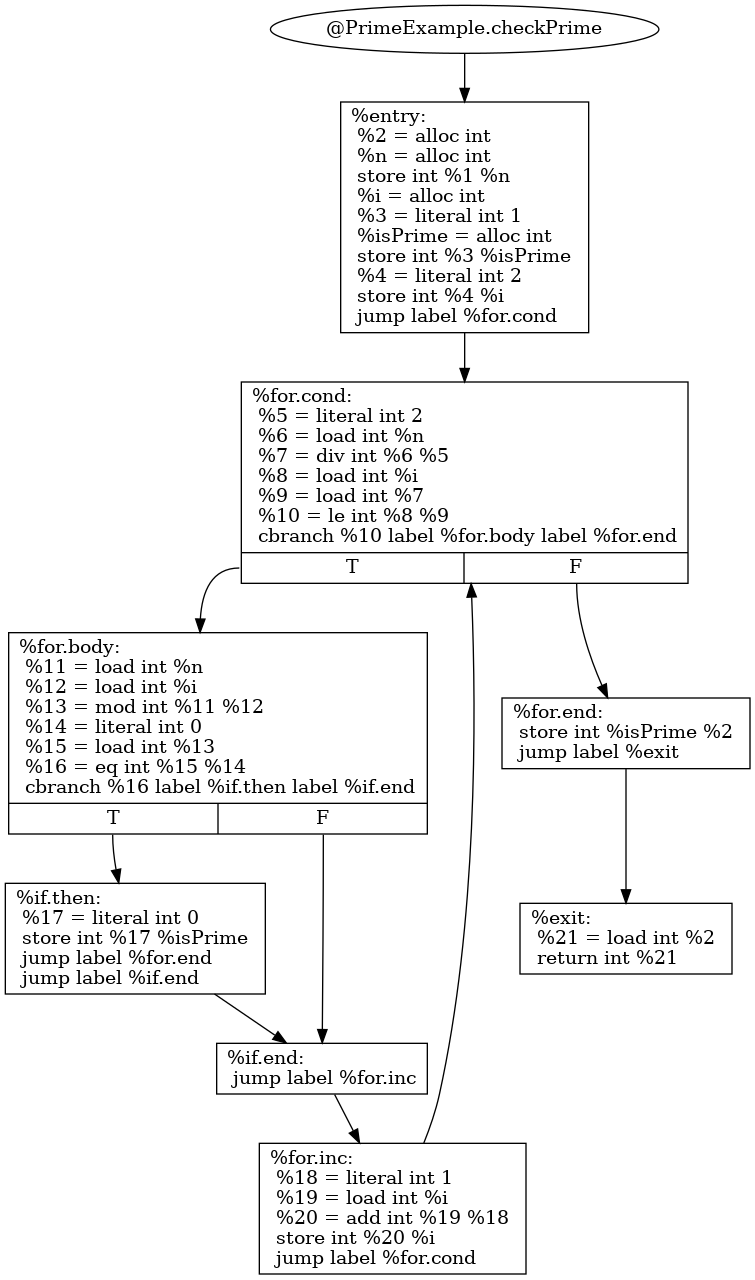